### Hybrid Popularity Model for Solving Cold-start Problem in Recommendation System
---
Based on: https://dl.acm.org/doi/pdf/10.1145/3427423.3427425

In [108]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# from kmodes.kmodes import KModes
# from fcmeans import FCM

## Toy Example
---

In [120]:
# Table 1. Toy example of rating data
#df = pd.read_csv('data/toy_example.csv', index_col=0)
df = pd.read_csv(Path('res','data','article_df.csv'), index_col = 0)
zero_mask = df == 0
df

,1,2,3,4,5,6,7
user,,,,,,,
1,3,4,0,5,2,0,0
2,0,5,5,4,0,3,3
3,2,3,3,0,2,4,3
4,0,0,0,0,0,0,0


In [121]:
# Table 2. Toy example of item popularity model 𝑰𝑰
ip = df.sum(axis=0)
max_ip = max(ip)
ip_norm = ip / max_ip

ip_df = pd.DataFrame([ip, ip_norm], index=["Item Popularity", "Item Popularity (Normalized)"])
ip_df

,1,2,3,4,5,6,7
Item Popularity,5.000000,12.0,8.000000,9.00,4.000000,7.000000,6.0
Item Popularity (Normalized),0.416667,1.0,0.666667,0.75,0.333333,0.583333,0.5


In [117]:
# Table 3. Toy example of user popularity model
up = df.sum(axis=1)
max_up = max(up)
up_norm = up / max_up

up_df = pd.DataFrame([up, up_norm], index=["Item Popularity", "Item Popularity (Normalized)"])
up_df.T

,Item Popularity,Item Popularity (Normalized)
user,,
1,14.0,0.7
2,20.0,1.0
3,18.0,0.9
4,0.0,0.0


In [118]:
# Table 4. Toy example of user-item popularity model
xv, yv = np.meshgrid(up_norm, ip_norm, indexing='ij')
uip = xv / yv
uip[zero_mask] = 0
uip = pd.DataFrame(uip, columns=df.columns, index=df.index)
uip

,1,2,3,4,5,6,7
user,,,,,,,
1,1.68,0.7,0.00,0.84,2.1,0.000000,0.0
2,0.00,1.0,1.50,1.20,0.0,1.714286,2.0
3,2.16,0.9,1.35,1.08,2.7,1.542857,1.8
4,0.00,0.0,0.00,0.00,0.0,0.000000,0.0


In [122]:
# Table 5. Toy example of hybrid popularity model 
alpha = 0.9

hp = alpha * ip_norm + (1 - alpha) * uip[:3].sum()

hp_df = pd.DataFrame([hp], index=["Hybrid Popularity"]).T
hp_df.sort_values("Hybrid Popularity", ascending=False)

,Hybrid Popularity
2,1.160000
4,0.987000
3,0.885000
6,0.850714
7,0.830000
5,0.780000
1,0.759000


# 5.1 Dataset and Experiment Setup
---
- Source: https://grouplens.org/datasets/movielens/100k/

In [123]:
# Ratings
raw = pd.read_csv(Path('res','data','ratings.csv'))#, names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings = pd.pivot_table(raw, index='user_id', columns=['movie_id'], values='rating')
#ratings = raw.pivot(index='user_id', columns=['item_id'], values='rating')
ratings = ratings.fillna(0)
print(ratings.shape)
ratings.head()

(943, 1682)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
all_ratings = pd.pivot_table(raw, index="user_id", columns="movie_id", values="rating")

In [125]:
# Split train/test
np.random.seed(123)
training_ids = np.random.choice(all_ratings.index, np.int32(937*0.9), replace=False)
train_ratings = all_ratings[all_ratings.index.isin(training_ids)]
test_ratings = all_ratings[~all_ratings.index.isin(training_ids)]

no_rating_mask = train_ratings.isna()
print(test_ratings.shape)

(100, 1682)


In [126]:
# Item popularity
ip = train_ratings.sum(axis=0)
max_ip = max(ip)
ip_norm = ip / max_ip

In [127]:
# Item popularity
up = train_ratings.sum(axis=1)
# up = up.sort_values(ascending=False)[:40]
max_up = max(up)
up_norm = up / max_up

In [128]:
# User Item Popularity
xv, yv = np.meshgrid(up_norm, ip_norm, indexing='ij')
uip = xv / yv
uip = pd.DataFrame(uip, columns=train_ratings.columns, index=train_ratings.index)
uip[no_rating_mask] = 0
uip

C:\Users\wypyc\AppData\Local\Temp\ipykernel_15408\3695210043.py:3: RuntimeWarning: divide by zero encountered in divide
  uip = xv / yv


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.674077,2.768899,4.268263,1.569579,4.218245,12.412306,0.807078,1.372135,1.000807,3.395820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.157879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.795355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.345275,1.418285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.526494,0.000000,0.000000,0.000000,0.000000,0.000000,0.630376,1.071719,0.781689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137585,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
938,0.242311,0.000000,0.000000,0.000000,0.000000,0.000000,0.290121,0.000000,0.359761,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213003,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
# HPop
alpha = 0.9
hp = (alpha * ip_norm) + ((1 - alpha) * uip.sum())

In [132]:
# NDCG@1
N = 20 # number of recommended items
IDCG = np.sum(1 / (np.log2(1+np.arange(1, N+1))))
# Calculated for all users and items
hpop_top_N = hp.sort_values(ascending=False).head(N)
# Top 10 Recommended Items 
hpop_top_N.index

Index([ 852,  830,  784,  599, 1494, 1493, 1486, 1581,  957, 1568, 1569, 1570,
       1571, 1572, 1574, 1587, 1575, 1586, 1576, 1577],
      dtype='int64', name='movie_id')

In [133]:
ndcg = []
precision = []
recall = []
for ir, iuser in test_ratings.iterrows():
    hu = iuser[iuser.notna()].index
    nominator = len(set(hpop_top_N.index).intersection(set(hu)))
    # precision
    precision.append(nominator / N)
    # recall
    recall.append(nominator / len(hu))
    # DCGu(N)
    dcg_u = np.sum([n in hu for n in hpop_top_N.index] / (np.log2(np.arange(N)+2)))
    ndcg.append(dcg_u / IDCG)

In [134]:
100*np.mean(recall)

0.0036101083032490976

In [135]:
100*np.mean(precision)

0.05

In [136]:
np.mean(ndcg)

0.0004275831251503157

In [137]:
# NDCG@1
dict = {'ndcg':[],
        'precision':[],
        'recall':[]}
for alpha in [1,0.9,0]:
    hp = (alpha * ip_norm) + ((1 - alpha) * uip.sum())
    ndcg_mean = []
    precision_mean = []
    recall_mean = []
    for N in range(1,21):
        IDCG = np.sum(1 / (np.log2(1+np.arange(1, N+1))))
        # Calculated for all users and items
        hpop_top_N = hp.sort_values(ascending=False).head(N)
        # Top 10 Recommended Items 
        hpop_top_N.index
        ndcg = []
        precision = []
        recall = []
        for ir, iuser in test_ratings.iterrows():
            hu = iuser[iuser.notna()].index
            nominator = len(set(hpop_top_N.index).intersection(set(hu)))
            # precision
            precision.append(nominator / N)
            # recall
            recall.append(nominator / len(hu))
            # DCGu(N)
            dcg_u = np.sum([n in hu for n in hpop_top_N.index] / (np.log2(np.arange(N)+2)))
            ndcg.append(dcg_u / IDCG)
        ndcg_mean.append(100 * np.mean(ndcg))
        precision_mean.append(100 * np.mean(precision))
        recall_mean.append(100 * np.mean(recall))
    dict['ndcg'].append(ndcg_mean)
    dict['precision'].append(precision_mean)
    dict['recall'].append(recall_mean)

In [138]:
ndcg_I = dict['ndcg'][0]
ndcg_H = dict['ndcg'][1]
ndcg_U = dict['ndcg'][2]
len(dict)

3

Text(0, 0.5, 'NDCG@N')

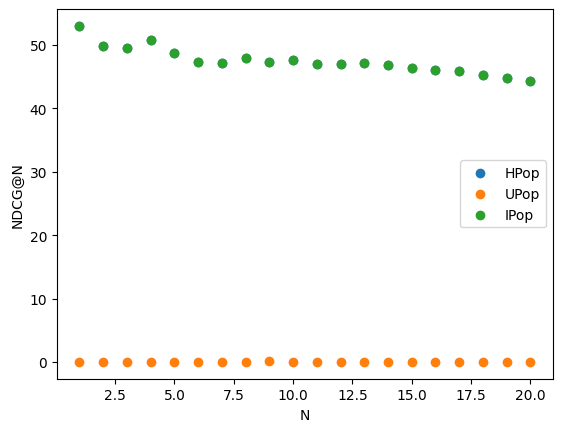

In [139]:
plt.scatter(np.arange(1,21), ndcg_I, label='HPop')
plt.scatter(np.arange(1,21), ndcg_U, label='UPop')
plt.scatter(np.arange(1,21), ndcg_I, label='IPop')
plt.legend()
plt.xlabel('N')
plt.ylabel('NDCG@N')